In [1]:
%reload_kedro

2020-03-11 22:33:20,450 - root - INFO - ** Kedro project Dynamic Topic Modeling
2020-03-11 22:33:20,453 - root - INFO - Defined global variable `context` and `catalog`
2020-03-11 22:33:20,472 - root - INFO - Registered line magic `run_viz`


In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [335]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Data

Computing inertia to improve $k$ with the elbow rule is time consuming and can't really get automated. Increasing $k$ according to the data needs to be done differently. We will focus on dynamic method with a fixed $k$ for now. 

In [47]:
dictionary = catalog.load("UN_dictionary")
token2id = dictionary.token2id

2020-03-10 20:37:53,997 - kedro.io.data_catalog - INFO - Loading data from `UN_dictionary` (DictionaryDataSet)...
2020-03-10 20:37:54,000 - gensim.utils - INFO - loading Dictionary object from data/05_model_input/UN_dictionary.dict
2020-03-10 20:37:54,023 - gensim.utils - INFO - loaded data/05_model_input/UN_dictionary.dict


In [48]:
BOW_train=catalog.load("BOW_train")
BOW_train

2020-03-10 20:37:58,700 - kedro.io.data_catalog - INFO - Loading data from `BOW_train` (ScipySparseMatrix)...


<5256x14598 sparse matrix of type '<class 'numpy.int32'>'
	with 1156353 stored elements in Compressed Sparse Row format>

In [50]:
BOW_train.getrow(55).data.sum()

181

In [49]:
timestamp_train = catalog.load("timestamp_train")
timestamp_train.head()

2020-03-10 20:38:00,525 - kedro.io.data_catalog - INFO - Loading data from `timestamp_train` (CSVLocalDataSet)...


,timeslice
0,24
1,3
2,44
3,4
4,30


For more interpretability, we have disabed bigrams, which weren't very valuable in the outputs of this method.

In [4]:
from sklearn.feature_extraction.text import TfidfTransformer

In [52]:
tfidf = TfidfTransformer().fit_transform(BOW_train)

In [5]:
import pickle

In [6]:
def top_terms(num_clusters, n_terms, id2token, order_centroids):
    top_terms = []*num_clusters
    for i in range(num_clusters):
        cluster_terms = []
        for ind in order_centroids[i,:n_terms]:
            cluster_terms.append(id2token[ind])
        top_terms.append(cluster_terms)
    return top_terms

In [7]:
def word_2_id(list_of_words) : 
    return [token2id[i] for i in list_of_words]

We will take the same data used in the DETM so we can compare metrics between DETM and different KMeans

In [7]:
from scipy.io import loadmat
tokens=loadmat('C:\\Users\\Gaspard\\statapp\\DETM-master\\data_undebates_largev\\split_paragraph_0\\min_df_100\\bow_tr_tokens')['tokens'][0]
counts=loadmat('C:\\Users\\Gaspard\\statapp\\DETM-master\\data_undebates_largev\\split_paragraph_0\\min_df_100\\bow_tr_counts')['counts'][0]
timestamp=loadmat('C://Users//Gaspard//statapp//DETM-master//data_undebates_largev//split_paragraph_0//min_df_100/bow_tr_timestamps.mat')['timestamps'][0]
with open('C:\\Users\\Gaspard\\statapp\\DETM-master\\data_undebates_largev\\split_paragraph_0\\min_df_100\\vocab.pkl','rb') as f :
    dictionary=pickle.load(f)

In [8]:
import scipy

In [9]:
bow=np.zeros((len(tokens),len(dictionary)))
for idx,tok in enumerate(tokens) : 
    tok=tok[0]
    bow[idx,tok]+=1

In [10]:
bow_tr=scipy.sparse.csr_matrix(bow)

In [191]:
bow_tr_norm=np.zeros((bow_tr.shape[0],bow_tr.shape[1]))
for idx in range((bow_tr.shape[0])) : 
    bow_tr_norm[idx]=bow_tr[idx]/bow_tr[idx].sum()

ValueError: setting an array element with a sequence.

In [11]:
tfidf=TfidfTransformer().fit_transform(bow_tr)

## Metrics : Topic Coherence & Topic Diversity

### Topic Coherence

In [12]:
def get_document_frequency(data, wi, wj=None):
    if wj is None:
        D_wi = 0
        for l in range(len(data)):
            doc = data[l].squeeze(0)
            if len(doc) == 1: 
                continue
                #doc = [doc.squeeze()]
            else:
                doc = doc.squeeze()
            if wi in doc:
                D_wi += 1
        return D_wi
    D_wj = 0
    D_wi_wj = 0
    for l in range(len(data)):
        doc = data[l].squeeze(0)
        if len(doc) == 1: 
            doc = [doc.squeeze()]
        else:
            doc = doc.squeeze()
        if wj in doc:
            D_wj += 1
            if wi in doc:
                D_wi_wj += 1
    return D_wj, D_wi_wj 

def get_topic_coherence(data, vocab,n_topics,top_words=None,beta=None):
    D = len(data) ## number of docs...data is list of documents
    print('Number of doc: ', D)
    TC = []
    num_topics = n_topics
    
    for k in range(num_topics):
        print('k: {}/{}'.format(k, num_topics))
        
        if top_words is None and beta is not None : 
            top_10 = list(beta[k].argsort()[-10:][::-1])
            top_words = [vocab[a] for a in top_10]
        elif top_words is None and beta is None :
            raise KeyError('You must specify either a top 10 terms or a beta matrix')
        else : 
            top_10=top_words[k]
        
        TC_k = 0
        counter = 0
        for i, word in enumerate(top_10):
            # get D(w_i)
            D_wi = get_document_frequency(data, word)
            p_wi=D_wi/D
            j = i + 1
            tmp = 0
            while j < len(top_10) and j > i:
                # get D(w_j) and D(w_i, w_j)
                D_wj, D_wi_wj = get_document_frequency(data, word, top_10[j])
                if D_wi_wj == 0 :
                    tc_pairwise=-1
                else : 
                    p_wj=D_wj/D
                    p_wi_wj=D_wi_wj/D

                    # get f(w_i, w_j)
                    tc_pairwise = np.log(p_wi_wj/(p_wi*p_wj))/-np.log(p_wi_wj)
                    # update tmp: 

                tmp += tc_pairwise
                j += 1
                counter += 1
            # update TC_k
            TC_k += tmp 
        print(TC_k/counter)
        TC.append(TC_k/counter)
                
    print('num topics: ', len(TC))
    #TC = np.mean(TC) / counter
    print('Topic Coherence is: {}'.format(TC))
    return TC



def model_topic_coherence(data,vocab,n_slices,n_topics,beta=None,top_words=None) : 
    
    if beta is  None and top_words is None : 
        raise KeyError('You must specify either a top 10 terms or a beta matrix')       
        
    tc=np.zeros((n_slices,n_topics))
    for timestep in range(n_slices): 
        print('-'*100)
        print('Timestep {}/{}'.format(timestep,n_slices))
        print('-'*100)
        print('\n')
        top_words_per_time=top_words[timestep]
        tc[timestep,:]=get_topic_coherence(data=data,vocab=vocab,n_topics=n_topics,top_words=top_words_per_time,beta=beta)
    return tc

### Topic Diversity

In [57]:
def _diversity_helper(top_words, num_tops=25):
    list_w = np.zeros((7, num_tops))
    for k in range(7):
        list_w[k, :] = top_words[k]
    list_w = np.reshape(list_w, (-1))
    list_w = list(list_w)
    n_unique = len(np.unique(list_w))
    diversity = n_unique / (7 * num_tops)
    return diversity

def get_TD_by_times(top_words,num_tops=25) :
    td=np.zeros(len(top_words),)
    for timestep in range(len(top_words)) : 
        top_w=top_words[timestep]
        td[timestep]=_diversity_helper(top_w,num_tops)
    return td

# K-means : year by year

In [14]:
from tqdm import tqdm

In [301]:
n_terms = 25
num_clusters = 7

cluster_terms_yby = []

km_yby = KMeans(n_clusters=num_clusters, n_jobs=-1)
km_yby.fit(tfidf[timestamp==0])
centroids_yby = km_yby.cluster_centers_
order_centroids_yby = centroids_yby.argsort()[:,::-1]

cluster_terms_yby.append(top_terms(num_clusters, n_terms, dictionary, order_centroids_yby))

for i in (range(1,len(np.unique(timestamp)))):
    km_yby = KMeans(n_clusters=num_clusters, n_jobs=-1, init=centroids_yby, n_init=1,random_state=2020)
    km_yby.fit(tfidf[timestamp==i])
    centroids_yby = km_yby.cluster_centers_
    order_centroids_yby = centroids_yby.argsort()[:,::-1]
    
    cluster_terms_yby.append(top_terms(num_clusters, n_terms, dictionary, order_centroids_yby))

In [71]:
for k in range(7) : 
    for time in [0,20,40]:
        print('Topic {} at time {} : {}'.format(k,time,cluster_terms_yby[time][k][:5]))
        print('\n')

Topic 0 at time 0 : ['twentyfifth', 'hijacking', 'tlatelolco', 'votes', 'bacteriological']
Topic 0 at time 20 : ['emotion', 'frontier', 'alter', 'speeches', 'renunciation']
Topic 0 at time 40 : ['explanation', 'sword', 'tells', 'insight', 'friction']
Topic 1 at time 0 : ['twentyfifth', 'rationalization', 'item', 'mrs', 'twelve']
Topic 1 at time 20 : ['principality', 'viewpoint', 'ratifying', 'eminently', 'examining']
Topic 1 at time 40 : ['invites', 'teach', 'reservation', 'worrying', 'knew']
Topic 2 at time 0 : ['twentyfifth', 'reply', 'defense', 'hijacking', 'favor']
Topic 2 at time 20 : ['drugtrafficking', 'principality', 'viewpoint', 'guido', 'acknowledging']
Topic 2 at time 40 : ['worship', 'misunderstanding', 'provocative', 'investing', 'underestimate']
Topic 3 at time 0 : ['vietnam', 'twentyfifth', 'clique', 'imperialists', 'bissau']
Topic 3 at time 20 : ['negotiators', 'intervening', 'sombre', 'evacuation', 'irrevocable']
Topic 3 at time 40 : ['uniquely', 'separately', 'reexami

In [21]:
def word_2_id(list_of_words,vocab) : 
    return [vocab[word] for word in list_of_words]

### Representing topic quality

#### Topic Coherence

In [22]:
d=dict(zip(dictionary,range(len(dictionary))))
cluster_ids_yby=np.zeros((len(np.unique(timestamp)),num_clusters,10))
for timestep in range(len(np.unique(timestamp))) : 
    for topic in range(num_clusters) : 
        cluster_ids_yby[timestep,topic,:]=word_2_id(cluster_terms_yby[timestep][topic],d)[:10]

In [23]:
TC_yby=model_topic_coherence(data=tokens,vocab=dictionary,n_slices=len(np.unique(timestamp)),n_topics=num_clusters,beta=None,top_words=cluster_ids_yby)  


----------------------------------------------------------------------------------------------------
Timestep 0/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.0867648371974659
k: 1/7
0.17659384549339277
k: 2/7
0.32658753820829806
k: 3/7
0.2579906313479832
k: 4/7
0.3240417719115739
k: 5/7
0.21305420920424673
k: 6/7
0.3057538349056401
num topics:  7
Topic Coherence is: [0.0867648371974659, 0.17659384549339277, 0.32658753820829806, 0.2579906313479832, 0.3240417719115739, 0.21305420920424673, 0.3057538349056401]
----------------------------------------------------------------------------------------------------
Timestep 1/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.10361707601405702
k: 1/7
0.0896563451212861
k: 2/7
0.3766362137580427
k: 3/7
0.46907304961077845
k: 4/7
0.39601543917284554
k: 5/7
0.0922926244887446

0.10365269230594233
k: 2/7
0.07995705091443746
k: 3/7
0.4457741905902177
k: 4/7
0.0832103880041018
k: 5/7
0.06610357678036778
k: 6/7
0.07954603674905115
num topics:  7
Topic Coherence is: [0.0877530578289497, 0.10365269230594233, 0.07995705091443746, 0.4457741905902177, 0.0832103880041018, 0.06610357678036778, 0.07954603674905115]
----------------------------------------------------------------------------------------------------
Timestep 14/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.06729816455375079
k: 1/7
0.08175084754677245
k: 2/7
0.07757968372166696
k: 3/7
0.5053047731857098
k: 4/7
0.07825669536528962
k: 5/7
0.09795770826424663
k: 6/7
0.0704183486069881
num topics:  7
Topic Coherence is: [0.06729816455375079, 0.08175084754677245, 0.07757968372166696, 0.5053047731857098, 0.07825669536528962, 0.09795770826424663, 0.0704183486069881]
-----------------------------------------------------------

Topic Coherence is: [0.05643467380599433, 0.0510322983314439, 0.09363841513388683, 0.4902532075840658, 0.09451523736752897, 0.09401025135176608, 0.08430452371152784]
----------------------------------------------------------------------------------------------------
Timestep 27/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.06471673723095411
k: 1/7
0.06345284914165357
k: 2/7
0.07710904121452004
k: 3/7
0.3861905464702294
k: 4/7
0.0757679961112774
k: 5/7
0.1090604700579233
k: 6/7
0.07367094973624753
num topics:  7
Topic Coherence is: [0.06471673723095411, 0.06345284914165357, 0.07710904121452004, 0.3861905464702294, 0.0757679961112774, 0.1090604700579233, 0.07367094973624753]
----------------------------------------------------------------------------------------------------
Timestep 28/46
----------------------------------------------------------------------------------------------------


Number of

Timestep 40/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.07397155298426289
k: 1/7
0.044902913251829546
k: 2/7
0.0532552473896675
k: 3/7
0.28897317805108025
k: 4/7
0.05662716809204809
k: 5/7
0.06580352606500738
k: 6/7
0.06652041755165868
num topics:  7
Topic Coherence is: [0.07397155298426289, 0.044902913251829546, 0.0532552473896675, 0.28897317805108025, 0.05662716809204809, 0.06580352606500738, 0.06652041755165868]
----------------------------------------------------------------------------------------------------
Timestep 41/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.0849625687969109
k: 1/7
0.06396568386123422
k: 2/7
0.07877925252287007
k: 3/7
0.4057586412661553
k: 4/7
0.06774268326347961
k: 5/7
0.10403254191885508
k: 6/7
0.06741677811974688
num topics:  7
Topic Coherence is: [0.0849625687969109, 0.0639

In [27]:
print('Overall Topic Coherence : {}'.format(np.mean(TC_yby)))

Overall Topic Coherence : 0.13482708496094345


#### Topic diversity

In [302]:
cluster_ids_yby=np.zeros((len(np.unique(timestamp)),num_clusters,25))
for timestep in range(len(np.unique(timestamp))) : 
    for topic in range(num_clusters) : 
        cluster_ids_yby[timestep,topic,:]=word_2_id(cluster_terms_yby[timestep][topic],d)

In [303]:
TD_yby=get_TD_by_times(cluster_ids_yby)

In [304]:
print('Overall Topic Diversity : {}'.format(np.mean(TD_yby)))

Overall Topic Diversity : 0.9250931677018635


In [306]:
print('Overall Topic Quality : {}'.format(np.mean(TC_yby)*np.mean(TD_yby)))

Overall Topic Quality : 0.12472761511852745


#### Topic Diversity Intra Topic

In [308]:
def diversity_by_topics(top_words,num_tops=25) : 
    list_w = np.zeros((46, num_tops))
    for ts in range(46):
        list_w[ts, :] = top_words[ts]
    list_w = np.reshape(list_w, (-1))
    list_w = list(list_w)
    n_unique = len(np.unique(list_w))
    diversity = n_unique / (46 * num_tops)
    return diversity

TD_yby_top=np.zeros((7,))
for k in range(7) :
    TD_yby_top[k]=diversity_by_topics(cluster_ids[:,k,:])

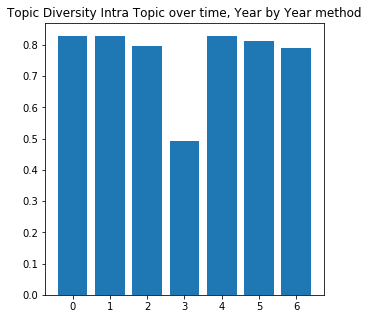

In [309]:
plt.figure(figsize=(5,5))
plt.bar(x=[i for i in range(7)],height=TD_yby_top)
plt.title('Topic Diversity Intra Topic over time, Year by Year method')
plt.show()

Clustering year by year isn't effective, as the previous years have the same weight as a single document of the current year. The clusters change too drastically and don't have any link from a year to another.

Instead, we add years one by one until all the data is included, while keeping the means initialized where the previous clusters were.

The metrics of Topic Quality gives pretty good results, however, we can see when chekcing topic diversity over topics that they are drastically different  

In [320]:
np.unique(km_yby.predict(tfidf),return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([   1,    1,    1,    1,    1, 6374,    1], dtype=int64))

In [349]:
def n_docs_in_topic(kmeans) :
    topic,counts=np.unique(kmeans.predict(tfidf),return_counts=True)
    return dict(zip(topic,counts))

In [344]:
def print_data(tc,td_by_times,td_by_topic,kmeans) : 
    
    tc_by_topic=np.zeros((8,))
    tc_std=np.zeros((8,))
    
    for k in range(7) : 
        tc_by_topic[k]=np.mean(tc[:,k]) 
        tc_std[k]=np.std(tc[:,k])
    
    tc_std[7]=np.std(tc)
    tc_by_topic[7]=np.mean(tc)
    
    tc_by_topic=pd.Series(tc_by_topic,name='Topic Coherence')
    tc_std=pd.Series(tc_std,name='Topic Coherence std')
    topic=pd.Series(['1','2','3','4','5','6','7','Total'],name='Topic')
     
    td_by_topic=pd.Series(list(td_by_topic)+[np.mean(td_by_topic)],name='Topic Diversity by topic')
    td_by_time=pd.Series([np.nan]*7+[np.mean(td_by_times)],name='Topic Diversity by times')
        
    n_doc_per_topic=pd.Series(n_docs_in_topic(kmeans),name='Number of docs in topic')
    return pd.DataFrame([topic,tc_by_topic,tc_std,td_by_topic,td_by_time,n_doc_per_topic]).T

In [345]:
print_data(TC,TD_yby,TD_yby_top,km_yby)

,Topic,Topic Coherence,Topic Coherence std,Topic Diversity by topic,Topic Diversity by times,Number of docs in topic
0,1,0.0829539,0.0270962,0.828696,NaN,1
1,2,0.0858084,0.0239059,0.827826,NaN,1
2,3,0.103481,0.0681252,0.797391,NaN,1
3,4,0.403301,0.098591,0.492174,NaN,1
4,5,0.0993054,0.06372,0.827826,NaN,1
5,6,0.08085,0.0279667,0.813043,NaN,6374
6,7,0.0880898,0.0376791,0.791304,NaN,1
7,Total,0.134827,0.123313,0.768323,0.925093,NaN


# K-means : additive method

In [17]:
n_terms = 25
num_clusters = 7

In [73]:
cluster_terms_add = []

km_add = KMeans(n_clusters=num_clusters, n_jobs=-1)
km_add.fit(tfidf[timestamp == 0])
centroids_add = km_add.cluster_centers_
order_centroids_add = centroids_add.argsort()[:,::-1]

cluster_terms_add.append(top_terms(num_clusters, n_terms, dictionary, order_centroids_add))

for i in tqdm(range(1,len(np.unique(timestamp)))):
    km_add = KMeans(n_clusters=num_clusters, n_jobs=-1, init=centroids_add, n_init=1,random_state=2020)
    km_add.fit(tfidf[timestamp <= i])
    centroids_add = km_add.cluster_centers_
    order_centroids_add = centroids_add.argsort()[:,::-1]
    
    cluster_terms_add.append(top_terms(num_clusters, n_terms, dictionary, order_centroids_add))


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 38/45 [35:59<07:13, 61.98s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [47:31<00:00, 93.93s/it]


In [346]:
for k in range(7) : 
    for time in [0,20,40]:
        print('Topic {} at time {} : {}'.format(k,time,cluster_terms_add[time][k][:5]))
    print('\n')

Topic 0 at time 0 : ['twentyfifth', 'quarter', 'portugal', 'jordan', 'salisbury']
Topic 0 at time 20 : ['monopolies', 'communist', 'ussr', 'circles', 'capitalist']
Topic 0 at time 40 : ['monopolies', 'communist', 'ussr', 'circles', 'capitalist']


Topic 1 at time 0 : ['mrs', 'thant', 'twentyfifth', 'vietnam', 'bissau']
Topic 1 at time 20 : ['twentyfifth', 'mrs', 'thant', 'vietnam', 'bissau']
Topic 1 at time 40 : ['twentyfifth', 'mrs', 'thant', 'vietnam', 'bissau']


Topic 2 at time 0 : ['francisco', 'san', 'twentyfifth', 'hijacking', 'failures']
Topic 2 at time 20 : ['francisco', 'san', 'twentyfifth', 'hijacking', 'failures']
Topic 2 at time 40 : ['francisco', 'san', 'twentyfifth', 'hijacking', 'failures']


Topic 3 at time 0 : ['jarring', 'mrs', 'twentyfifth', 'machinery', 'limitation']
Topic 3 at time 20 : ['powers', 'mankind', 'man', 'present', 'race']
Topic 3 at time 40 : ['apartheid', 'mankind', 'independence', 'namibia', 'south']


Topic 4 at time 0 : ['twentyfifth', 'thant', 'mr

In [355]:
d=dict(zip(dictionary,range(len(dictionary))))
cluster_ids_add=np.zeros((len(np.unique(timestamp)),num_clusters,10))
for timestep in range(len(np.unique(timestamp))) : 
    for topic in range(num_clusters) : 
        cluster_ids_add[timestep,topic,:]=word_2_id(cluster_terms_add[timestep][topic],d)[:10]
        
TC_add=model_topic_coherence(data=tokens,vocab=dictionary,n_slices=len(np.unique(timestamp)),n_topics=num_clusters,beta=None,top_words=cluster_ids_add)  


----------------------------------------------------------------------------------------------------
Timestep 0/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.23457912665130987
k: 1/7
0.2716159713735115
k: 2/7
0.13223411532761623
k: 3/7
0.19175552821490752
k: 4/7
0.3055053349296162
k: 5/7
0.2759374504383928
k: 6/7
0.32658753820829806
num topics:  7
Topic Coherence is: [0.23457912665130987, 0.2716159713735115, 0.13223411532761623, 0.19175552821490752, 0.3055053349296162, 0.2759374504383928, 0.32658753820829806]
----------------------------------------------------------------------------------------------------
Timestep 1/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.27885694204684275
k: 1/7
0.2896527292785406
k: 2/7
0.13223411532761623
k: 3/7
0.39644451459035
k: 4/7
0.3829792471202633
k: 5/7
0.41471699273123225

k: 4/7
0.32409592295763273
k: 5/7
0.25586382793146917
k: 6/7
0.3543255722356236
num topics:  7
Topic Coherence is: [0.42107923819366855, 0.2896527292785406, 0.13223411532761623, 0.2905920730862715, 0.32409592295763273, 0.25586382793146917, 0.3543255722356236]
----------------------------------------------------------------------------------------------------
Timestep 14/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.42107923819366855
k: 1/7
0.2896527292785406
k: 2/7
0.13223411532761623
k: 3/7
0.2905920730862715
k: 4/7
0.34087104174981975
k: 5/7
0.2625954156762946
k: 6/7
0.3554609380123537
num topics:  7
Topic Coherence is: [0.42107923819366855, 0.2896527292785406, 0.13223411532761623, 0.2905920730862715, 0.34087104174981975, 0.2625954156762946, 0.3554609380123537]
----------------------------------------------------------------------------------------------------
Timestep 15/46
--------------------

----------------------------------------------------------------------------------------------------
Timestep 27/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.42107923819366855
k: 1/7
0.2896527292785406
k: 2/7
0.13223411532761623
k: 3/7
0.2624663261999938
k: 4/7
0.30326946536528243
k: 5/7
0.24322325050059043
k: 6/7
0.36342734846040126
num topics:  7
Topic Coherence is: [0.42107923819366855, 0.2896527292785406, 0.13223411532761623, 0.2624663261999938, 0.30326946536528243, 0.24322325050059043, 0.36342734846040126]
----------------------------------------------------------------------------------------------------
Timestep 28/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.42107923819366855
k: 1/7
0.2896527292785406
k: 2/7
0.13223411532761623
k: 3/7
0.2624663261999937
k: 4/7
0.30326946536528243
k: 5/7
0.1836425718

0.2896527292785406
k: 2/7
0.13223411532761623
k: 3/7
0.25001696598539375
k: 4/7
0.30326946536528243
k: 5/7
0.15486633903385197
k: 6/7
0.36216607426304975
num topics:  7
Topic Coherence is: [0.42107923819366855, 0.2896527292785406, 0.13223411532761623, 0.25001696598539375, 0.30326946536528243, 0.15486633903385197, 0.36216607426304975]
----------------------------------------------------------------------------------------------------
Timestep 41/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.42107923819366855
k: 1/7
0.2896527292785406
k: 2/7
0.13223411532761623
k: 3/7
0.25001696598539375
k: 4/7
0.30326946536528243
k: 5/7
0.12994539225535615
k: 6/7
0.3471351085722029
num topics:  7
Topic Coherence is: [0.42107923819366855, 0.2896527292785406, 0.13223411532761623, 0.25001696598539375, 0.30326946536528243, 0.12994539225535615, 0.3471351085722029]
--------------------------------------------------------

In [356]:
print('Overall Topic Coherence : {}'.format(np.mean(TC_add)))

Overall Topic Coherence : 0.28442661345524506


In [77]:
cluster_ids_add=np.zeros((len(np.unique(timestamp)),num_clusters,25))
for timestep in range(len(np.unique(timestamp))) : 
    for topic in range(num_clusters) : 
        cluster_ids_add[timestep,topic,:]=word_2_id(cluster_terms_add[timestep][topic],d)


In [78]:
TD_add=get_TD_by_times(cluster_ids_add)

In [357]:
print('Overall Topic Diversity : {}'.format(np.mean(TD_add)))

Overall Topic Diversity : 0.8478260869565217


In [358]:
print('Overall Topic Quality : {}'.format(np.mean(TC_add)*np.mean(TD_add)))

Overall Topic Quality : 0.24114430271205559


#### Topic Diversiry Intra Cluster

In [97]:
def diversity_by_topics(top_words,num_tops=25) : 
    list_w = np.zeros((46, num_tops))
    for ts in range(46):
        list_w[ts, :] = top_words[ts]
    list_w = np.reshape(list_w, (-1))
    list_w = list(list_w)
    n_unique = len(np.unique(list_w))
    diversity = n_unique / (46 * num_tops)
    return diversity

TD_all_top=np.zeros((7,))
for k in range(7) :
    TD_all_top[k]=diversity_by_topics(cluster_ids_add[:,k,:])
    


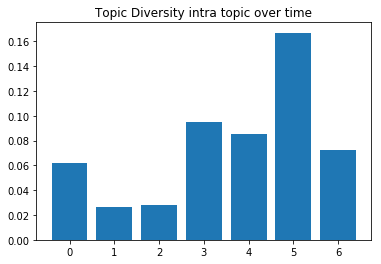

In [101]:
plt.bar(x=[i for i in range(7)],height=TD_all_top)
plt.title('Topic Diversity intra topic over time')
plt.show()

Very little Diversity within same topics over time. It means that the topic pratically don't change over time. 
So this technique might be not good. 

Take a look at a full topic over time : 

In [126]:
for tt in range(46) : 
    print(cluster_terms_add[tt][1][:10])

['mrs', 'thant', 'twentyfifth', 'vietnam', 'bissau', 'sale', 'lusaka', 'portugal', 'guinea', 'commemorative']
['twentyfifth', 'mrs', 'thant', 'vietnam', 'bissau', 'sale', 'portugal', 'guinea', 'portuguese', 'lusaka']
['twentyfifth', 'mrs', 'thant', 'vietnam', 'bissau', 'sale', 'portugal', 'guinea', 'portuguese', 'lusaka']
['twentyfifth', 'mrs', 'thant', 'vietnam', 'bissau', 'sale', 'portugal', 'guinea', 'portuguese', 'lusaka']
['twentyfifth', 'mrs', 'thant', 'vietnam', 'bissau', 'sale', 'portugal', 'guinea', 'portuguese', 'lusaka']
['twentyfifth', 'mrs', 'thant', 'vietnam', 'bissau', 'sale', 'portugal', 'guinea', 'portuguese', 'lusaka']
['twentyfifth', 'mrs', 'thant', 'vietnam', 'bissau', 'sale', 'portugal', 'guinea', 'portuguese', 'lusaka']
['twentyfifth', 'mrs', 'thant', 'vietnam', 'bissau', 'sale', 'portugal', 'guinea', 'portuguese', 'lusaka']
['twentyfifth', 'mrs', 'thant', 'vietnam', 'bissau', 'sale', 'portugal', 'guinea', 'portuguese', 'lusaka']
['twentyfifth', 'mrs', 'thant', 'v

In [347]:
print_data(TC_add,TD_add,TD_all_top,km_add)

,Topic,Topic Coherence,Topic Coherence std,Topic Diversity by topic,Topic Diversity by times,Number of docs in topic
0,1,0.0934601,0.0348568,0.0617391,NaN,1
1,2,0.0769573,0.0189353,0.026087,NaN,1
2,3,0.107582,0.0365521,0.0278261,NaN,1
3,4,0.140877,0.109447,0.0947826,NaN,1
4,5,0.139621,0.134744,0.0852174,NaN,1
5,6,0.134483,0.0737247,0.166957,NaN,6374
6,7,0.114003,0.0663364,0.0721739,NaN,1
7,Total,0.115283,0.0815057,0.0763975,0.847826,NaN


In [ ]:
pickle.dump(cluster_terms, open( "all_nogram.p", "wb" ))

In [ ]:
cluster_terms = pickle.load(open( "all_nogram.p", "rb" ))

In [359]:
print_data(TC_add,TD_add,TD_all_top,km_add)

,Topic,Topic Coherence,Topic Coherence std,Topic Diversity by topic,Topic Diversity by times,Number of docs in topic
0,1,0.394888,0.0539454,0.0617391,NaN,17
1,2,0.289261,0.00263031,0.026087,NaN,8
2,3,0.132476,0.000914755,0.0278261,NaN,10
3,4,0.286717,0.0832924,0.0947826,NaN,1851
4,5,0.310054,0.0179436,0.0852174,NaN,151
5,6,0.220592,0.0743106,0.166957,NaN,3348
6,7,0.357,0.0165124,0.0721739,NaN,995
7,Total,0.284427,0.093572,0.0763975,0.847826,NaN


This method seems to detect strong changes but isn't very flexible. Let's use a slinding window.

# K-means : sliding window

In [133]:
def inbetween(i, timestamp, w_size):
    return timestamp[(timestamp <= i) & (timestamp > i-w_size)]

In [140]:
timestamp

array([40,  0, 17, ...,  5, 45,  5], dtype=int64)

In [146]:
tfidf[timestamp<5]

<475x6934 sparse matrix of type '<class 'numpy.float64'>'
	with 354522 stored elements in Compressed Sparse Row format>

In [185]:
w_size = 10

cluster_terms_sw5 = []

km_sw5 = KMeans(n_clusters=num_clusters, n_jobs=-1,random_state=2020)
km_sw5.fit(tfidf[timestamp == 0])
centroids_sw5 = km_sw5.cluster_centers_
order_centroids_sw5 = centroids_sw5.argsort()[:,::-1]

cluster_terms_sw5.append(top_terms(num_clusters, n_terms, dictionary, order_centroids_sw5))

for i in tqdm(range(1,len(np.unique(timestamp)))):
    km_sw5 = KMeans(n_clusters=num_clusters, n_jobs=-1, init=centroids_sw5, n_init=1,random_state=2020,max_iter=500)
    if i>w_size-1:
        km_sw5.fit(tfidf[inbetween(i, timestamp, w_size)])
    else:
        km_sw5.fit(tfidf[timestamp <= i])
    centroids_sw5 = km_sw5.cluster_centers_
    order_centroids_sw5 = centroids_sw5.argsort()[:,::-1]
    
    cluster_terms_sw5.append(top_terms(num_clusters, n_terms, dictionary, order_centroids_sw5))




  0%|                                                                                                                                           | 0/45 [00:00<?, ?it/s]


  2%|██▉                                                                                                                                | 1/45 [00:00<00:20,  2.12it/s]


  4%|█████▊                                                                                                                             | 2/45 [00:01<00:27,  1.56it/s]


  7%|████████▋                                                                                                                          | 3/45 [00:06<01:20,  1.92s/it]


  9%|███████████▋                                                                                                                       | 4/45 [00:10<01:46,  2.60s/it]


 11%|██████████████▌                                                                                                                    | 5/45 [00:

For w_size=5, we get the following clusters :

In [160]:
for k in range(7) : 
    for time in [0,20,40]:
        print('Topic {} at time {} : {}'.format(k,time,cluster_terms_sw5[time][k][:5]))
    print('\n')

Topic 0 at time 0 : ['aggressions', 'indochinese', 'thant', 'clique', 'frontier']
Topic 0 at time 20 : ['occurrence', 'shortest', 'invites', 'interpretations', 'yearn']
Topic 0 at time 40 : ['recurring', 'friction', 'concentrating', 'excellence', 'disagreements']


Topic 1 at time 0 : ['estimates', 'preoccupation', 'programs', 'twentyfifth', 'suggested']
Topic 1 at time 20 : ['spelled', 'accompanying', 'worried', 'inaugural', 'indivisibility']
Topic 1 at time 40 : ['bottom', 'strait', 'owed', 'migratory', 'visions']


Topic 2 at time 0 : ['twentyfifth', 'mrs', 'quarter', 'francisco', 'vietnam']
Topic 2 at time 20 : ['delegates', 'euphoria', 'unfavorable', 'raids', 'skilled']
Topic 2 at time 40 : ['topical', 'expenses', 'commemorated', 'streamline', 'theatre']


Topic 3 at time 0 : ['twentyfifth', 'mrs', 'seabed', 'anniversary', 'jordan']
Topic 3 at time 20 : ['winter', 'medicines', 'watched', 'divine', 'prompts']
Topic 3 at time 40 : ['constructed', 'topical', 'vertical', 'mountains', 

In [21]:
pickle.dump(cluster_terms, open( "wsize5_nogram.p", "wb" ))

In [22]:
cluster_terms = pickle.load(open( "wsize5_nogram.p", "rb" ))

In [162]:
for i in range(46):
    print(cluster_terms_sw5[i][6][:5])

['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['venue', 'symbolizes', 'debilitating', 'hindrance', 'topical']
['venue', 'symbolizes', 'debilitating', 'hindrance', 'topical']
['venue', 'symbolizes', 'debilitating', 'hindrance', 'topical']
['modify', 'arouse', 'adhering', 'visavis', 'santiago']
['modify', 'arouse', 'adhering', 'visavis', 'santiago']
['modify', 'arouse', 'adhering', 'visavis', 'santiago']
['modify', 'a

This model is much less stable but enables to show that the sliding window allows more change in the topic meaning. However, we can see that the global topic meaning strongly changed.

With w_size = 10, we get :

In [165]:
d=dict(zip(dictionary,range(len(dictionary))))
cluster_ids_sw5=np.zeros((len(np.unique(timestamp)),num_clusters,10))
for timestep in range(len(np.unique(timestamp))) : 
    for topic in range(num_clusters) : 
        cluster_ids_sw5[timestep,topic,:]=word_2_id(cluster_terms_sw5[timestep][topic],d)[:10]
        
TC_add=model_topic_coherence(data=tokens,vocab=dictionary,n_slices=len(np.unique(timestamp)),n_topics=num_clusters,beta=None,top_words=cluster_ids_sw5)  

----------------------------------------------------------------------------------------------------
Timestep 0/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.15383292218104716
k: 1/7
0.09792694470249332
k: 2/7
0.17152223979531522
k: 3/7
0.18963844642588473
k: 4/7
0.3084612935711353
k: 5/7
0.31368065349696345
k: 6/7
0.22786494942674804
num topics:  7
Topic Coherence is: [0.15383292218104716, 0.09792694470249332, 0.17152223979531522, 0.18963844642588473, 0.3084612935711353, 0.31368065349696345, 0.22786494942674804]
----------------------------------------------------------------------------------------------------
Timestep 1/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.15383292218104716
k: 1/7
0.09792694470249332
k: 2/7
0.17152223979531522
k: 3/7
0.18963844642588473
k: 4/7
0.3084612935711353
k: 5/7
0.313680653

0.07370002002389879
k: 2/7
0.06564530473489415
k: 3/7
0.0344577136951456
k: 4/7
0.129442299269894
k: 5/7
0.09879734197651846
k: 6/7
0.05444059448342379
num topics:  7
Topic Coherence is: [0.06843181384669259, 0.07370002002389879, 0.06564530473489415, 0.0344577136951456, 0.129442299269894, 0.09879734197651846, 0.05444059448342379]
----------------------------------------------------------------------------------------------------
Timestep 14/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.06843181384669259
k: 1/7
0.07370002002389879
k: 2/7
0.06564530473489415
k: 3/7
0.0344577136951456
k: 4/7
0.129442299269894
k: 5/7
0.09879734197651846
k: 6/7
0.09378123866510105
num topics:  7
Topic Coherence is: [0.06843181384669259, 0.07370002002389879, 0.06564530473489415, 0.0344577136951456, 0.129442299269894, 0.09879734197651846, 0.09378123866510105]
--------------------------------------------------------------

Topic Coherence is: [0.07024052450399071, 0.07712086036111086, 0.09329397408241041, 0.08825404848769143, 0.037243536502675936, 0.07876714757921296, 0.05987492124712145]
----------------------------------------------------------------------------------------------------
Timestep 27/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.08944538902682433
k: 1/7
0.07712086036111086
k: 2/7
0.09329397408241041
k: 3/7
0.08825404848769143
k: 4/7
0.037243536502675936
k: 5/7
0.07876714757921296
k: 6/7
0.05987492124712145
num topics:  7
Topic Coherence is: [0.08944538902682433, 0.07712086036111086, 0.09329397408241041, 0.08825404848769143, 0.037243536502675936, 0.07876714757921296, 0.05987492124712145]
----------------------------------------------------------------------------------------------------
Timestep 28/46
----------------------------------------------------------------------------------------------------


Timestep 40/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.06661712334253687
k: 1/7
0.0876853060452798
k: 2/7
0.0906707054405447
k: 3/7
0.08579552051318985
k: 4/7
0.11366263201116238
k: 5/7
0.12799895713132708
k: 6/7
0.07591754131702577
num topics:  7
Topic Coherence is: [0.06661712334253687, 0.0876853060452798, 0.0906707054405447, 0.08579552051318985, 0.11366263201116238, 0.12799895713132708, 0.07591754131702577]
----------------------------------------------------------------------------------------------------
Timestep 41/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.06661712334253687
k: 1/7
0.0876853060452798
k: 2/7
0.0906707054405447
k: 3/7
0.08579552051318985
k: 4/7
0.06057562886686242
k: 5/7
0.12799895713132708
k: 6/7
0.07591754131702577
num topics:  7
Topic Coherence is: [0.06661712334253687, 0.0876853

In [166]:
print('Overall Topic Coherence : {}'.format(np.mean(TC_add)))

Overall Topic Coherence : 0.11528344783504865


In [167]:
cluster_ids_sw5=np.zeros((len(np.unique(timestamp)),num_clusters,25))
for timestep in range(len(np.unique(timestamp))) : 
    for topic in range(num_clusters) : 
        cluster_ids_sw5[timestep,topic,:]=word_2_id(cluster_terms_sw5[timestep][topic],d)
TD_sw5=get_TD_by_times(cluster_ids_sw5)
print('Overall Topic Diversity : {}'.format(np.mean(TD_sw5)))
print('Overall Topic Quality : {}'.format(np.mean(TC_add)*np.mean(TD_sw5)))

Overall Topic Diversity : 0.9407453416149067
Overall Topic Quality : 0.10845236651612712


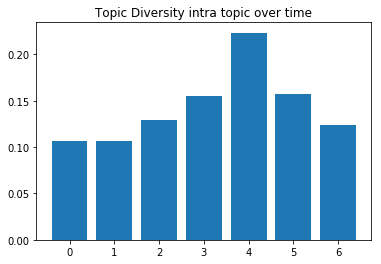

In [168]:
def diversity_by_topics(top_words,num_tops=25) : 
    list_w = np.zeros((46, num_tops))
    for ts in range(46):
        list_w[ts, :] = top_words[ts]
    list_w = np.reshape(list_w, (-1))
    list_w = list(list_w)
    n_unique = len(np.unique(list_w))
    diversity = n_unique / (46 * num_tops)
    return diversity

TD_sw5_top=np.zeros((7,))
for k in range(7) :
    TD_sw5_top[k]=diversity_by_topics(cluster_ids_sw5[:,k,:])
    
plt.bar(x=[i for i in range(7)],height=TD_sw5_top)
plt.title('Topic Diversity intra topic over time')
plt.show()

In [169]:
for i in range(46):
    print(cluster_terms_sw5[i][6][:5])

['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['mrs', 'jarring', 'twentyfifth', 'vietnam', 'aircraft']
['venue', 'symbolizes', 'debilitating', 'hindrance', 'topical']
['venue', 'symbolizes', 'debilitating', 'hindrance', 'topical']
['venue', 'symbolizes', 'debilitating', 'hindrance', 'topical']
['modify', 'arouse', 'adhering', 'visavis', 'santiago']
['modify', 'arouse', 'adhering', 'visavis', 'santiago']
['modify', 'arouse', 'adhering', 'visavis', 'santiago']
['modify', 'a

In [351]:
print_data(TC_add,TD_sw5,TD_sw5_top,km_sw5)

,Topic,Topic Coherence,Topic Coherence std,Topic Diversity by topic,Topic Diversity by times,Number of docs in topic
0,1,0.0934601,0.0348568,0.106957,NaN,1
1,2,0.0769573,0.0189353,0.106957,NaN,1
2,3,0.107582,0.0365521,0.129565,NaN,1
3,4,0.140877,0.109447,0.155652,NaN,1
4,5,0.139621,0.134744,0.223478,NaN,6374
5,6,0.134483,0.0737247,0.157391,NaN,1
6,7,0.114003,0.0663364,0.124348,NaN,1
7,Total,0.115283,0.0815057,0.143478,0.940745,NaN


# Topic visualisation

In [170]:
import matplotlib.pyplot as plt

In [28]:
import pickle
cluster_terms = pickle.load(open( "wsize5_nogram.p", "rb" ))

In [291]:
def print_top_terms(n_topic, n_terms, max_t,cluster_terms):
    dic={}
    for tt in range(max_t) : 
        for word in cluster_terms_sw5[tt][n_topic] :
            if word in dic.keys() : 

                dic[word]+=1
            else :
                dic[word]=1
        
    dic_sorted={k: v for k, v in sorted(dic.items(), key=lambda item: item[1],reverse=True)}
    
    top_words=list(dic_sorted.keys())[:20]
    
    words = {e:[0] * max_t for e in set(top_words)}
    for i in range(max_t):
        for word in top_words:
            try :
                words[word][i] = cluster_terms[i][n_topic].index(word)+1
            except :
                words[word][i]=0

    x = range(max_t)

    plt.figure(figsize=(20,10))
    plt.xlabel("timestamps")
    plt.ylabel("words rank for topic %d"% n_topic)
    for word, ranks in words.items():
        plt.plot(x, ranks, label = word)
    plt.legend()
    plt.show()

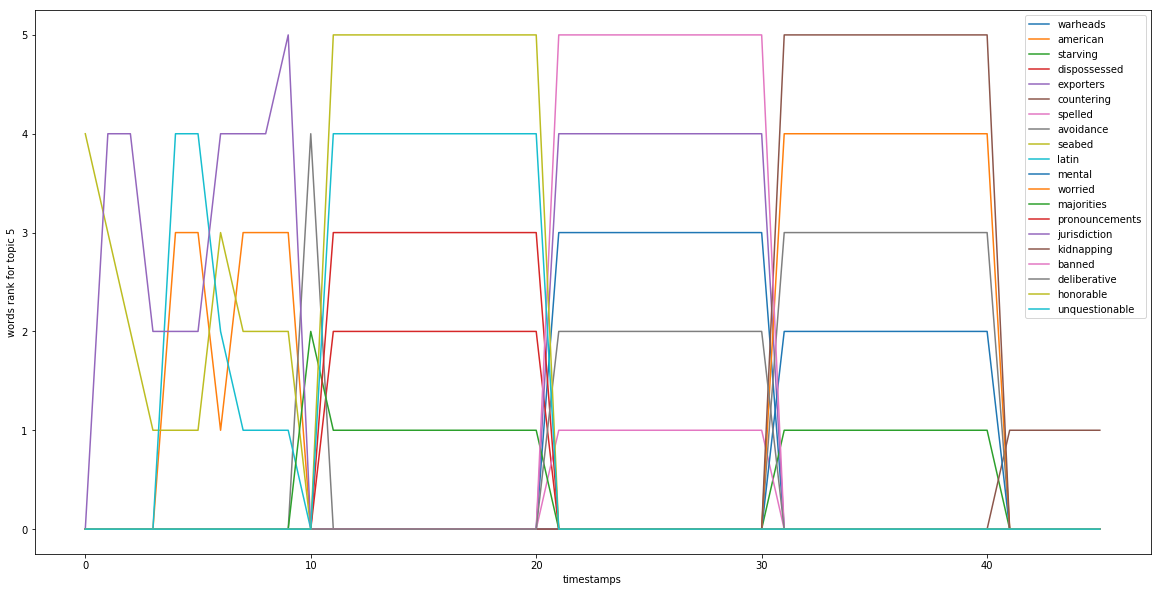

In [293]:

n_topic = 5
n_terms = 5
max_t = len(np.unique(timestamp))
print_top_terms(n_topic, n_terms, max_t, cluster_terms_sw5)

# Word2Vec and k-means

In [1]:
import numpy as np

In [2]:
Glove_embeddings = catalog.load("Glove_embeddings")

NameError: name 'catalog' is not defined

In [36]:
un_embeddings = dict()

vocab_size = len(dictionary)
words_found = 0
for token_id in tqdm(range(vocab_size)):
    word = dictionary[token_id]
    try:
        un_embeddings[word] = Glove_embeddings[word]
        words_found += 1
    except KeyError:
        un_embeddings[word] = np.array([0]*300)

print("Number of words found on embedding : {} out of {}".format(words_found, vocab_size))

100%|██████████| 12459/12459 [00:00<00:00, 614042.20it/s]

Number of words found on embedding : 12422 out of 12459


In [38]:
from sklearn.cluster import KMeans
from tqdm import tqdm

In [39]:
emb_size = 300
num_clusters = 3

In [104]:
km = KMeans(n_clusters=num_clusters, n_jobs=-1)
km.fit(list(un_embeddings.values()))
centroids = km.cluster_centers_
order_centroids = centroids.argsort()[:,::-1]

In [41]:
def distances(embeddings, center):
    dists = dict()
    for word in embeddings.keys():
        dists[word] = [np.linalg.norm(embeddings[word] - center)]
    return dists

In [42]:
dists = [distances(un_embeddings, center) for center in order_centroids]

In [43]:
from seaborn import heatmap

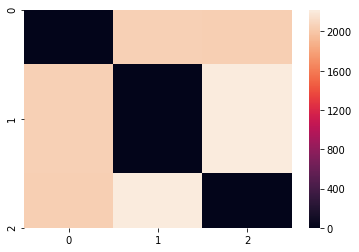

In [44]:
heatmap([[np.linalg.norm(center1 - center2) for center2 in order_centroids] for center1 in order_centroids])

In [45]:
for center in order_centroids:
    d = distances(un_embeddings, center)
    print(sorted(d, key=d.get)[:5])

['socialist', 'somali', 'boigny', 'nguema', 'pluralist']
['pseudo', 'socialist', 'melanesian', 'nguema', 'leninist']
['somali', 'graf', 'infantry', 'army', 'battalion']


In [101]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

In [ ]:
points = pd.DataFrame(TSNE(n_components=2).fit_transform(list(un_embeddings.values())))
points['target'] = km.labels_

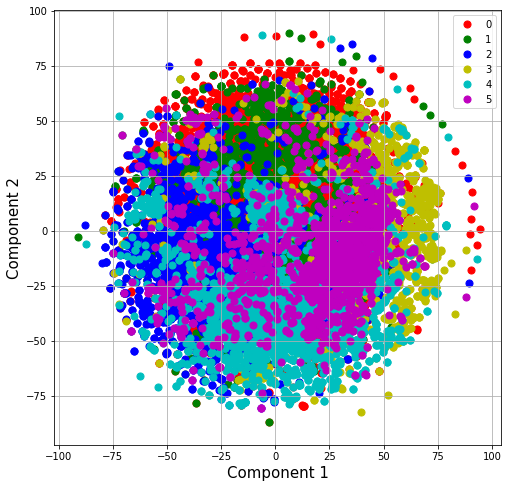

In [107]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)

targets = [0, 1, 2, 3, 4, 5]
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for target, color in zip(targets, colors):
    indicesToKeep = points['target'] == target
    ax.scatter(points.loc[indicesToKeep, 0]
               , points.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Document embeddings and kmeans

There, we want to clusterize documents themselves, by the mean of their embeddings. We can use the previous versions of kmeans to get the same results.

In [73]:
def generate_doc_embedding_mean(doc_index, BOW, id2token, emb_size):
    doc_embedding = np.zeros((1, emb_size))
    __, cols = BOW.getrow(doc_index).nonzero()
    for word_id in cols:
        try:
            doc_embedding += Glove_embeddings[id2token[word_id]]
        except:
            pass
    return doc_embedding / BOW_train.getrow(doc_index).sum()

In [74]:
doc_embeddings = np.zeros((BOW_train.shape[0], emb_size))

for doc_index in tqdm(range(BOW_train.shape[0])):
    doc_embeddings[doc_index] = generate_doc_embedding_mean(doc_index, BOW_train, dictionary, emb_size)

100%|██████████| 5256/5256 [00:15<00:00, 344.44it/s]


In [83]:
inertie = []

for k in tqdm(range(2, 20)):
    km = KMeans(n_clusters=k, n_jobs=-1)
    km.fit(doc_embeddings)
    inertie.append(km.inertia_)

100%|██████████| 18/18 [00:18<00:00,  1.00s/it]


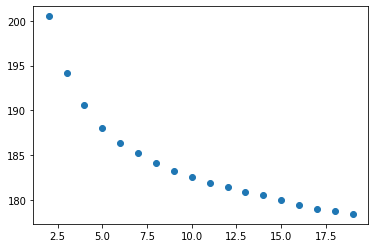

In [86]:
plt.scatter(range(2,20), inertie)

In [87]:
num_clusters = 6

In [108]:
km = KMeans(n_clusters=num_clusters, n_jobs=-1)
km.fit(doc_embeddings)
centroids = km.cluster_centers_
order_centroids = centroids.argsort()[:,::-1]

In [109]:
points = pd.DataFrame(TSNE(n_components=2).fit_transform(doc_embeddings))
points['target'] = km.labels_

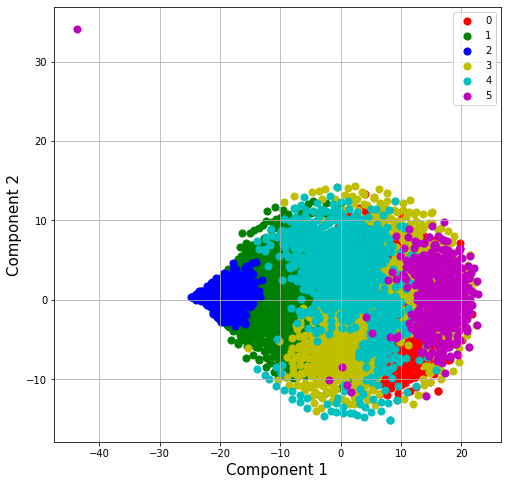

In [111]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)

targets = [0, 1, 2, 3, 4, 5]
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for target, color in zip(targets, colors):
    indicesToKeep = points['target'] == target
    ax.scatter(points.loc[indicesToKeep, 0]
               , points.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [119]:
def generate_doc_embedding_max(doc_index, BOW, id2token, emb_size):
    doc_embedding = np.zeros((1, emb_size))
    __, cols = BOW.getrow(doc_index).nonzero()
    for word_id in cols:
        try:
            doc_embedding = np.maximum(doc_embedding, Glove_embeddings[id2token[word_id]])
        except:
            pass
    return doc_embedding

In [122]:
doc_embeddings_max = np.zeros((BOW_train.shape[0], emb_size))

for doc_index in tqdm(range(BOW_train.shape[0])):
    doc_embeddings_max[doc_index] = generate_doc_embedding_max(doc_index, BOW_train, dictionary, emb_size)

100%|██████████| 5256/5256 [00:16<00:00, 324.83it/s]


In [130]:
inertie = []

for k in tqdm(range(2, 15)):
    km = KMeans(n_clusters=k, n_jobs=-1)
    km.fit(doc_embeddings_max)
    inertie.append(km.inertia_)

100%|██████████| 13/13 [00:11<00:00,  1.18it/s]


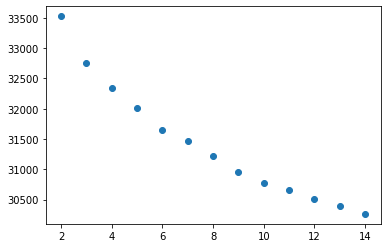

In [133]:
plt.scatter(range(2,15), inertie)

In [134]:
num_clusters = 10

In [135]:
km = KMeans(n_clusters=num_clusters, n_jobs=-1)
km.fit(doc_embeddings_max)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [136]:
points = pd.DataFrame(TSNE(n_components=2).fit_transform(doc_embeddings_max))
points['target'] = km.labels_

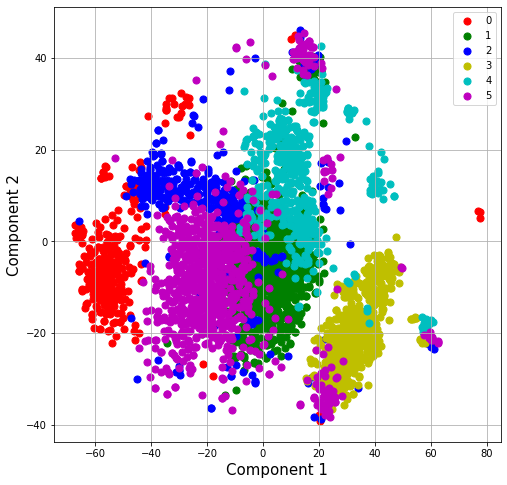

In [137]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)

targets = [0, 1, 2, 3, 4, 5]
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for target, color in zip(targets, colors):
    indicesToKeep = points['target'] == target
    ax.scatter(points.loc[indicesToKeep, 0]
               , points.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()